## Generating PD and Default intensity from Rating transition matrix

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import matrix_power

In [26]:
# CARE rating - Issuer weighted average transition rates – 2007/2017
data = {
    'AAA': [0.9773, 0.0156, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
    'AA':  [0.0227, 0.9392, 0.0346, 0.0006, 0.0002, 0.0000, 0.0000, 0.0000],
    'A':   [0.0000, 0.0408, 0.8815, 0.0448, 0.0000, 0.0000, 0.0000, 0.0000],
    'BBB': [0.0000, 0.0015, 0.0696, 0.8791, 0.0548, 0.0015, 0.0191, 0.0000],
    'BB':  [0.0000, 0.0015, 0.0085, 0.0540, 0.8535, 0.1335, 0.0892, 0.0000],
    'B':   [0.0000, 0.0007, 0.0012, 0.0033, 0.0311, 0.7567, 0.2166, 0.0000],
    'C':   [0.0000, 0.0000, 0.0004, 0.0001, 0.0028, 0.0037, 0.3631, 0.0000],
    'D':   [0.0000, 0.0007, 0.0042, 0.0181, 0.0576, 0.1046, 0.3120, 1.0000]
}

index = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'C', 'D']

In [27]:
# Convert the percentages into fractions
transition_matrix = pd.DataFrame(data, index=index)

# List to collect all matrices with year and "From" rating
all_matrices = []

# Calculate PD matrices for each year from 1 to 40
for year in range(1, 41):
    # Calculate the matrix for the current year
    pd_matrix = np.linalg.matrix_power(transition_matrix.values, year)
    
    # Convert the matrix to a DataFrame
    pd_matrix_df = pd.DataFrame(pd_matrix, index=index, columns=index)
    
    # Add "Year" and "From" columns
    pd_matrix_df.insert(0, "From", index)  
    pd_matrix_df.insert(0, "Year", year)
    
    # Append the resulting DataFrame to the list
    all_matrices.append(pd_matrix_df)

# Concatenate all matrices into one large DataFrame
output_df = pd.concat(all_matrices)

# Reset index and save the final DataFrame to a CSV file
output_file = '40_Years_PD_Matrices_Probabilities.csv'
output_df.reset_index(drop=True, inplace=True)
output_df.to_csv(output_file, index=False)

print(f"All PD matrices from year 1 to 40 have been saved in {output_file}.")

All PD matrices from year 1 to 40 have been saved in 40_Years_PD_Matrices_Probabilities.csv.


In [33]:
pd_matrices_df = pd.read_csv(r'C:\\Users\\Admin\\Downloads\\40_Years_PD_Matrices_Probabilities.csv')

# Extract the relevant columns: "Year", "From", and "D"
default_probabilities = pd_matrices_df[['Year', 'From', 'D']]

default_probabilities_pivot = default_probabilities.pivot(index='From', columns='Year', values='D')
desired_order = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'C', 'D']
default_probabilities_pivot_ordered = default_probabilities_pivot.reindex(desired_order)

output_file = 'PD_Over_40_Years.csv'
default_probabilities_pivot_ordered.to_csv(output_file)

print(default_probabilities_pivot_ordered.head())

Year      1         2         3         4         5         6         7   \
From                                                                       
AAA   0.0000  0.000016  0.000054  0.000123  0.000229  0.000381  0.000586   
AA    0.0007  0.001716  0.003076  0.004801  0.006907  0.009403  0.012296   
A     0.0042  0.009926  0.016996  0.025265  0.034605  0.044890  0.056002   
BBB   0.0181  0.037687  0.058399  0.079906  0.101926  0.124220  0.146593   
BB    0.0576  0.111880  0.162416  0.209208  0.252431  0.292322  0.329137   

Year        8         9         10  ...        31        32        33  \
From                                ...                                 
AAA   0.000851  0.001186  0.001597  ...  0.036478  0.039567  0.042782   
AA    0.015587  0.019275  0.023353  ...  0.172536  0.181215  0.189923   
A     0.067826  0.080256  0.093190  ...  0.376899  0.388567  0.399994   
BBB   0.168887  0.190975  0.212756  ...  0.553336  0.564359  0.575015   
BB    0.363133  0.394556  0.4

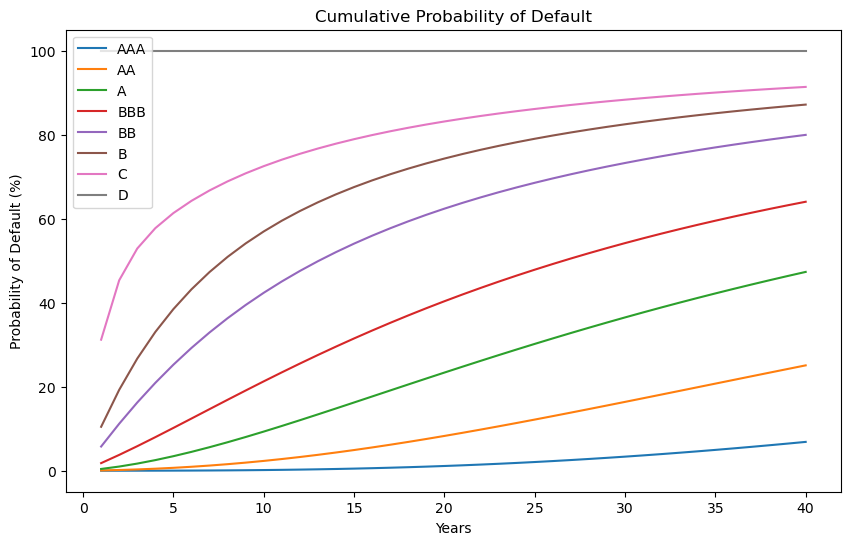

In [36]:
# Plot the cumulative probabilities
plt.figure(figsize=(10, 6))

for rating in desired_order:
    plt.plot(default_probabilities_pivot_ordered.columns, 
             default_probabilities_pivot_ordered.loc[rating] * 100,
             label=rating)

plt.title('Cumulative Probability of Default')
plt.xlabel('Years')
plt.ylabel('Probability of Default (%)')
plt.legend()

plt.show()

In [38]:
# Default intensity
default_probabilities = default_probabilities_pivot_ordered 

# Create a new DataFrame to store the default intensity
default_intensity = pd.DataFrame(index=default_probabilities.index, columns=default_probabilities.columns)

# Calculate the default intensity for each rating and year
for rating in default_probabilities.index:
    for year in default_probabilities.columns[1:]:
        # Calculate P_t - P_t-1
        delta_p = default_probabilities.loc[rating, year] - default_probabilities.loc[rating, year - 1]
        
        # Ensure delta_p is within valid range for the log function
        if delta_p < 1:
            # Apply the default intensity formula
            default_intensity.loc[rating, year] = -np.log(1 - delta_p)
        else:
            # If the delta_p is 1 or greater, the intensity should be undefined or set to a high value
            default_intensity.loc[rating, year] = np.nan

# Fill the first column (since we don't have a P_t-1 for year 1) with NaN or a default value
default_intensity[1] = np.nan

# Display the first few rows of the default intensity
print(default_intensity.head())

Year  1         2         3         4         5         6         7   \
From                                                                   
AAA  NaN  0.000016  0.000039  0.000069  0.000106  0.000152  0.000205   
AA   NaN  0.001016  0.001361  0.001727  0.002108    0.0025  0.002897   
A    NaN  0.005743  0.007095  0.008304  0.009383  0.010338  0.011174   
BBB  NaN  0.019781  0.020929  0.021742  0.022265  0.022546  0.022627   
BB   NaN  0.055809  0.051857  0.047923  0.044185  0.040708   0.03751   

Year        8         9         10  ...        31        32        33  \
From                                ...                                 
AAA   0.000266  0.000335  0.000411  ...  0.002964  0.003093  0.003221   
AA    0.003297  0.003694  0.004086  ...  0.008676  0.008717  0.008746   
A     0.011895  0.012508  0.013019  ...   0.01198  0.011736  0.011492   
BBB   0.022546  0.022335  0.022021  ...  0.011472  0.011085  0.010713   
BB    0.034587  0.031927   0.02951  ...  0.008151  0.0077

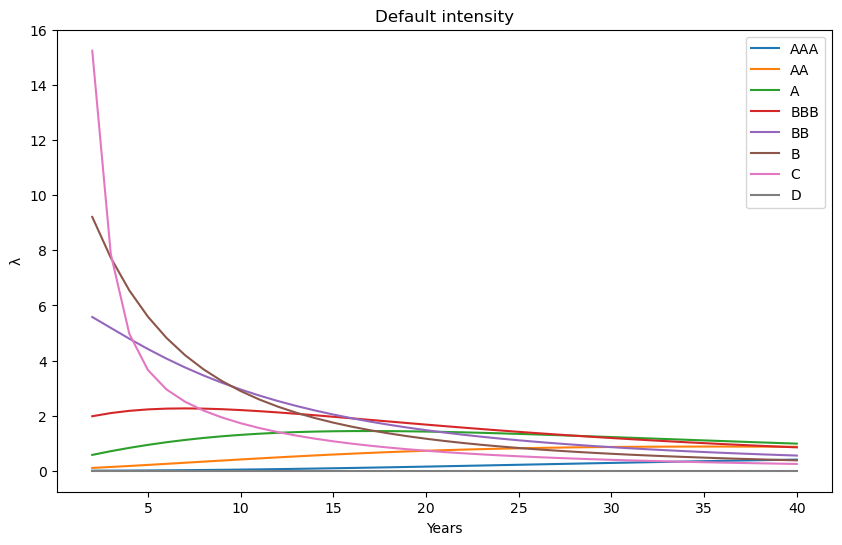

In [41]:
# Plot the default intensity
plt.figure(figsize=(10, 6))

for rating in desired_order:
    plt.plot(default_intensity.columns, 
             default_intensity.loc[rating] * 100,
             label=rating)

plt.title('Default intensity')
plt.xlabel('Years')
plt.ylabel('λ')
plt.legend()

plt.show()